In [2]:
!pip install tensorflow

     -------------------------------------- 276.5/276.5 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 1.7 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
     -------------------------------------- 440.8/440.8 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 2.1 MB/s eta 0:00:00
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp38-cp38-win_amd64.whl (1.5 MB)
     ---------------------------------------- 4.3/4.3 MB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 1.9 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 1.7/1.7 MB 2.2 MB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     -------------------------------------- 130.2/130.2 kB 2.6 MB/s eta 0:00:0

In [3]:
from __future__ import division
import math
import json
import random
import pprint
import scipy.misc
import numpy as np
from time import gmtime, strftime
from six.moves import xrange
import PIL
from PIL import Image
from PIL import ImageFont, ImageDraw
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import imageio


from __future__ import division
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

import math
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import initializers
import matplotlib.patches as patches
from matplotlib.patches import Patch
plt.style.use('dark_background')


In [5]:
!pip install google-colab


     -------------------------------------- 72.9/72.9 kB 803.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 64.2/64.2 kB 856.0 kB/s eta 0:00:00
     -------------------------------------- 104.5/104.5 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 758.9/758.9 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 8.0/8.0 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 11.8/11.8 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 58.0/58.0 kB 3.2 MB/s eta 0:00:00
     -------------------------------------- 484.2/484.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing met

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1964 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-38
      creating build\lib.win-amd64-cpython-38\pandas
      copying pandas\conftest.py -> build\lib.win-amd64-cpython-38\pandas
      copying pandas\testing.py -> build\lib.win-amd64-cpython-38\pandas
      copying pandas\_version.py -> build\lib.win-amd64-cpython-38\pandas
      copying pandas\__init__.py -> build\lib.win-amd64-cpython-38\pandas
      creating build\lib.win-amd64-cpython-38\pandas\api
      copying pandas\api\__init__.py -> build\lib.win-amd64-cpython-38\pandas\api
      creating build\lib.win-amd64-cpython-38\pandas\arrays
      copying pandas\arrays\__init__.py -> build\lib.win-amd64-cpython-38\pandas\arrays
      creating build\lib.win-amd64-cpython-38\pandas\compat
      copying pandas\com

In [16]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# os.environ['CUDA_VISIBLE_DEVICES']='1'
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# session = tf.compat.v1.Session(config=config)

In [17]:
def convert_to_cxywh(data):

    bboxes = data[...,0:4]
    labels = data[...,4:]
    mask = np.zeros_like(data[...,3:4])
    labels = np.concatenate((mask,labels), axis = 2)
    labels = np.argmax(labels,axis=2)
    class_info = np.expand_dims(labels, axis=2)
    cxywh = np.concatenate((class_info,bboxes), axis = 2)
    cxywh[..., 1] = cxywh[..., 1] - cxywh[..., 3]/2
    cxywh[..., 2] = cxywh[..., 2] - cxywh[..., 4]/2
    return cxywh

def generate_colors(class_names = None,n_class=50):
            cmap = ["","#dc143c","#ffff00","#00ff00","#ff00ff","#1e90ff","#fff5ee",
                    "#00ffff","#8b008b","#ff4500","#8b4513","#808000","#483d8b",
                    "#008000","#000080","#9acd32","#ffa500","#ba55d3","#00fa9a",
                    "#dc143c","#0000ff","#f08080","#f0e68c","#dda0dd","#ff1493"]
            colors = dict()
            if class_names == None:
                class_names = []
                for i in range(n_class):
                    class_names.append('class'+str(i+1))
            for i in range(n_class):
                colors[class_names[i]] = cmap[i]
            return colors

class_names = ['None', 'Text', 'Title', 'List', 'Table','Figure']
colors = generate_colors(n_class=6 , class_names=class_names)

def plot_layouts(pred,colors,class_names,path=""):
    height = 20
    width  = 12
    fig          = plt.figure(figsize=(width,height), dpi=40 ,facecolor=(0,0,0))
    height_ratio = [0.25,1,1,1,1]
    grid         = plt.GridSpec(5,4,
                        hspace=0.05,wspace=0.05,
                        height_ratios = height_ratio,
                        left=0.02,right=0.98,top=0.98,bottom=0.02)
    index = 0
    legend = []
    ax = fig.add_subplot(grid[index : index+4])
    index += 4
    for i in range(1,6):
        legend.append(Patch(facecolor=colors[class_names[i]]+"30",
                            edgecolor=colors[class_names[i]],
                            label= class_names[i]))

    ax.legend(handles=legend, ncol=3,loc=8, fontsize=25, facecolor=(0,0,0))
    ax.axis('off')

    for i in range(16):
        ax   = fig.add_subplot(grid[index])
        index += 1

        data = pred[i]
        rect1 = patches.Rectangle((0,0),180,240)
        rect1.set_color((0,0,0,1))
        ax.add_patch(rect1)
        for box in data:

            c,x,y,w,h = box
            if c==0:
                continue
            x = x*180
            y = y*240
            w = w*180
            h = h*240
            rect = patches.Rectangle((x,y),w,h,linewidth=4)
            rect.set_color(colors[class_names[int(c)]]+"00")
            rect.set_linestyle('-')
            rect.set_edgecolor(colors[class_names[int(c)]])
            ax.add_patch(rect)
        ax.plot()
        ax.set_facecolor((0,0,0))
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(path, facecolor=(0,0,0))



In [18]:

def layout_bbox(final_pred, output_height, output_width):
    final_pred = tf.reshape(final_pred, [64, 9, 9])
    bbox_reg = tf.slice(final_pred, [0, 0, 0], [-1, -1, 4])
    cls_prob = tf.slice(final_pred, [0, 0, 4], [-1, -1, 5])

    bbox_reg = tf.reshape(bbox_reg, [64, 9, 4])

    x_c = tf.slice(bbox_reg, [0, 0, 0], [-1, -1, 1]) * output_width
    y_c = tf.slice(bbox_reg, [0, 0, 1], [-1, -1, 1]) * output_height
    w   = tf.slice(bbox_reg, [0, 0, 2], [-1, -1, 1]) * output_width
    h   = tf.slice(bbox_reg, [0, 0, 3], [-1, -1, 1]) * output_height

    x1 = x_c - 0.5*w
    x2 = x_c + 0.5*w
    y1 = y_c - 0.5*h
    y2 = y_c + 0.5*h

    xt = tf.reshape(tf.range(output_width, dtype=tf.float32), [1, 1, 1, -1])
    xt = tf.reshape(tf.tile(xt, [64, 9, output_height, 1]), [64, 9, -1])

    yt = tf.reshape(tf.range(output_height, dtype=tf.float32), [1, 1, -1, 1])
    yt = tf.reshape(tf.tile(yt, [64, 9, 1, output_width]), [64, 9, -1])

    x1_diff = tf.reshape(xt-x1, [64, 9, output_height, output_width, 1])
    y1_diff = tf.reshape(yt-y1, [64, 9, output_height, output_width, 1])
    x2_diff = tf.reshape(x2-xt, [64, 9, output_height, output_width, 1])
    y2_diff = tf.reshape(y2-yt, [64, 9, output_height, output_width, 1])

    x1_line = tf.nn.relu(1.0 - tf.abs(x1_diff)) * tf.minimum(tf.nn.relu(y1_diff), 1.0) * tf.minimum(tf.nn.relu(y2_diff), 1.0)
    x2_line = tf.nn.relu(1.0 - tf.abs(x2_diff)) * tf.minimum(tf.nn.relu(y1_diff), 1.0) * tf.minimum(tf.nn.relu(y2_diff), 1.0)
    y1_line = tf.nn.relu(1.0 - tf.abs(y1_diff)) * tf.minimum(tf.nn.relu(x1_diff), 1.0) * tf.minimum(tf.nn.relu(x2_diff), 1.0)
    y2_line = tf.nn.relu(1.0 - tf.abs(y2_diff)) * tf.minimum(tf.nn.relu(x1_diff), 1.0) * tf.minimum(tf.nn.relu(x2_diff), 1.0)

    xy_max = tf.reduce_max(tf.concat([x1_line, x2_line, y1_line, y2_line], axis=-1), axis=-1, keepdims=True)

    spatial_prob = tf.multiply(tf.tile(xy_max, [1, 1, 1, 1, 5]), tf.reshape(cls_prob, [64, 9, 1, 1, 5]))
    spatial_prob_max = tf.reduce_max(spatial_prob, axis=1, keepdims=False)

    return spatial_prob_max

In [19]:
class RelationModule(tf.keras.Model):
    def __init__(self, channels=128,output_dim=128,key_dim=128,**kwargs):
        super(RelationModule, self).__init__(**kwargs)
        self.key_dim    = channels
        self.output_dim = channels
        self.channels   = channels
        self.key   = tf.keras.layers.Conv2D(output_dim, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.query = tf.keras.layers.Conv2D(key_dim, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.value = tf.keras.layers.Conv2D(key_dim, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.projection = tf.keras.layers.Conv2D(channels, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))

    def call(self, inputs):
        f_k = tf.reshape( self.key(inputs),[inputs.shape[0],inputs.shape[1]*inputs.shape[2],self.key_dim])
        f_q = tf.reshape(self.query(inputs),[inputs.shape[0],inputs.shape[1]*inputs.shape[2],self.key_dim])
        f_q = tf.transpose(f_q,perm=[0,2,1])
        f_v = tf.reshape(self.value(inputs),[inputs.shape[0],inputs.shape[1]*inputs.shape[2],self.output_dim])

        attention_weight = tf.matmul(f_k,f_q)/(inputs.shape[1]*inputs.shape[2])
        out = tf.matmul(tf.transpose(attention_weight,perm=[0,2,1]),f_v)
        out = tf.reshape(out,[inputs.shape[0],inputs.shape[1],inputs.shape[2],self.output_dim])
        out = self.projection(out)
        return out

class Discriminator(tf.keras.Model):
    def __init__(self, n_filters=32, n_hidden=128, layout_dim=(28,28),render=layout_bbox,**kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.layout_dim = layout_dim
        self.render = render
        self.act   = tf.keras.layers.LeakyReLU(alpha = 0.2)
        self.conv1 = tf.keras.layers.Conv2D(32, (5,5),input_shape=layout_dim, strides=(2, 2), padding='valid', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn1   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)

        self.conv2 = tf.keras.layers.Conv2D(32*2, (5,5), strides=(2, 2), padding='valid', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn2   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1   = tf.keras.layers.Dense(512, kernel_initializer=initializers.RandomNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn3   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.fc2   = tf.keras.layers.Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))

    def call(self, inputs):
        x = self.render(inputs, self.layout_dim[0], self.layout_dim[1])
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.flatten(x)
        x = self.act(self.bn3(self.fc1(x)))
        out = self.fc2(x)
        return out

class Generator(tf.keras.Model):
    def __init__(self, n_filters=128,output_dim=2,n_component=128,n_class=1,include_probability=False,**kwargs):
        super(Generator, self).__init__(**kwargs)
        self.n_filters   = n_filters
        self.output_dim  = output_dim
        self.n_component = n_component
        self.n_class = n_class
        self.include_probability = include_probability

        self.act   = tf.keras.layers.ReLU()
        self.conv1_1 = tf.keras.layers.Conv2D(n_filters//4, (1,1),input_shape=(self.n_component,1,self.n_class+self.output_dim), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn1_1   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.conv1_2 = tf.keras.layers.Conv2D(n_filters//16, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn1_2   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.conv1_3 = tf.keras.layers.Conv2D(n_filters//16, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn1_3   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.conv1_4 = tf.keras.layers.Conv2D(n_filters//4, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn1_4   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)

        self.relation1 = RelationModule(channels=n_filters//4,output_dim=n_filters//4,key_dim=n_filters//4)
        self.relation2 = RelationModule(channels=n_filters//4,output_dim=n_filters//4,key_dim=n_filters//4)
        self.relation3 = RelationModule(channels=n_filters,output_dim=n_filters,key_dim=n_filters)
        self.relation4 = RelationModule(channels=n_filters,output_dim=n_filters,key_dim=n_filters)


        self.bn_x1   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.bn_x2   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.bn_x3   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.bn_x4   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)

        self.bn_x5   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.bn_x6   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.bn_x7   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.bn_x8   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)

        self.conv2_1 = tf.keras.layers.Conv2D(n_filters, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn2_1   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.conv2_2 = tf.keras.layers.Conv2D(n_filters//4, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn2_2   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.conv2_3 = tf.keras.layers.Conv2D(n_filters//4, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn2_3   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.conv2_4 = tf.keras.layers.Conv2D(n_filters, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.bn2_4   = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum = 0.9)
        self.geometric_param = tf.keras.layers.Conv2D(output_dim, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.001, mean = 0.0),bias_initializer=initializers.constant(0.0))
        self.class_score = tf.keras.layers.Conv2D(n_class, (1,1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean = 0.0),bias_initializer=initializers.constant(0.0))

    def call(self, x):
        x = tf.reshape(x, [x.shape[0], self.n_component, 1, self.n_class+self.output_dim])
        h1_0 = self.bn1_1(self.conv1_1(x))
        h1_1 = self.act(self.bn1_2(self.conv1_2(x)))
        h1_2 = self.act(self.bn1_3(self.conv1_3(h1_1)))
        h1_3 = self.bn1_4(self.conv1_4(h1_2))
        embedding = self.act(tf.add(h1_0,h1_3))
        embedding = tf.reshape(embedding,[x.shape[0],self.n_component,1,256])

        context = self.act(self.bn_x2(tf.add(embedding,self.bn_x1(self.relation1(embedding)))))
        context = self.act(self.bn_x4(tf.add(context,self.bn_x3(self.relation2(context)))))

        h2_0 = self.bn2_1(self.conv2_1(context))
        h2_1 = self.act(self.bn2_2(self.conv2_2(h2_0)))
        h2_2 = self.act(self.bn2_3(self.conv2_3(h2_1)))
        h2_3 = self.bn2_4(self.conv2_4(h2_2))
        decoded = self.act(tf.add(h2_0,h2_3))

        decoded = self.act(self.bn_x6(tf.add(decoded,self.bn_x5(self.relation3(decoded)))))
        decoded = self.act(self.bn_x8(tf.add(decoded,self.bn_x7(self.relation4(decoded)))))

        out = self.geometric_param(decoded)
        out = tf.sigmoid(tf.reshape(out,[-1,self.n_component,self.output_dim]))

        cls_score = self.class_score(decoded)
        cls_prob  = tf.sigmoid(tf.reshape(cls_score,[-1,self.n_component,self.n_class]))
        final_pred = tf.concat([out,cls_prob],axis=-1)
        return final_pred


In [20]:
#Download it from "https://drive.google.com/file/d/1YQKyASvGDNUTJnE1x-Q2ZhhiY0VFj7oZ/view?usp=sharing"
dataset_path = r"E:\Anna University BOOKS & NOTES\SEVENTH SEMESTER\FYP\Phase1\sorted_c1publay.npy"
#provide directory for storing predictions
sam_dir = r"E:\Anna University BOOKS & NOTES\SEVENTH SEMESTER\FYP\Phase1\Predictions"


Epoch: [ 0] [   0/1132] time: 6.4031, lr:2.000E-05, d_loss: 1.4150, g_loss: 0.7965
[Sample] d_loss: 1.44201279, g_loss: 0.76694250
Epoch: [ 0] [   1/1132] time: 14.3008, lr:2.000E-05, d_loss: 1.4313, g_loss: 0.7911
[Sample] d_loss: 1.41572559, g_loss: 0.79010057
Epoch: [ 0] [   2/1132] time: 25.3694, lr:2.000E-05, d_loss: 1.4108, g_loss: 0.7761
[Sample] d_loss: 1.41871715, g_loss: 0.78651011
Epoch: [ 0] [   3/1132] time: 39.5978, lr:2.000E-05, d_loss: 1.4209, g_loss: 0.7812
[Sample] d_loss: 1.41605544, g_loss: 0.78788161
Epoch: [ 0] [   4/1132] time: 48.6035, lr:2.000E-05, d_loss: 1.4208, g_loss: 0.7721
[Sample] d_loss: 1.40955710, g_loss: 0.78633761
Epoch: [ 0] [   5/1132] time: 57.4135, lr:2.000E-05, d_loss: 1.4145, g_loss: 0.7826
[Sample] d_loss: 1.42050552, g_loss: 0.78519022
Epoch: [ 0] [   6/1132] time: 66.3069, lr:2.000E-05, d_loss: 1.4071, g_loss: 0.8029
[Sample] d_loss: 1.40728211, g_loss: 0.79505777
Epoch: [ 0] [   7/1132] time: 75.6066, lr:2.000E-05, d_loss: 1.4044, g_loss: 

C:\Users\aswin\AppData\Local\Temp\ipykernel_24512\3898280645.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig          = plt.figure(figsize=(width,height), dpi=40 ,facecolor=(0,0,0))


[Sample] d_loss: 1.38981903, g_loss: 0.77871555
Epoch: [ 0] [  21/1132] time: 205.4892, lr:2.000E-05, d_loss: 1.3714, g_loss: 0.7761
[Sample] d_loss: 1.38429022, g_loss: 0.78005111
Epoch: [ 0] [  22/1132] time: 218.6617, lr:2.000E-05, d_loss: 1.3549, g_loss: 0.8024
[Sample] d_loss: 1.38525987, g_loss: 0.78834891
Epoch: [ 0] [  23/1132] time: 231.1989, lr:2.000E-05, d_loss: 1.3780, g_loss: 0.7755
[Sample] d_loss: 1.38437247, g_loss: 0.78345430
Epoch: [ 0] [  24/1132] time: 243.7174, lr:2.000E-05, d_loss: 1.3764, g_loss: 0.7724
[Sample] d_loss: 1.37732899, g_loss: 0.78454411
Epoch: [ 0] [  25/1132] time: 255.8476, lr:2.000E-05, d_loss: 1.3706, g_loss: 0.7728
[Sample] d_loss: 1.38030767, g_loss: 0.77226567
Epoch: [ 0] [  26/1132] time: 268.8424, lr:2.000E-05, d_loss: 1.3865, g_loss: 0.7781
[Sample] d_loss: 1.37714422, g_loss: 0.77963531
Epoch: [ 0] [  27/1132] time: 281.2533, lr:2.000E-05, d_loss: 1.3710, g_loss: 0.7789
[Sample] d_loss: 1.37547362, g_loss: 0.78327215
Epoch: [ 0] [  28/113

KeyboardInterrupt: 

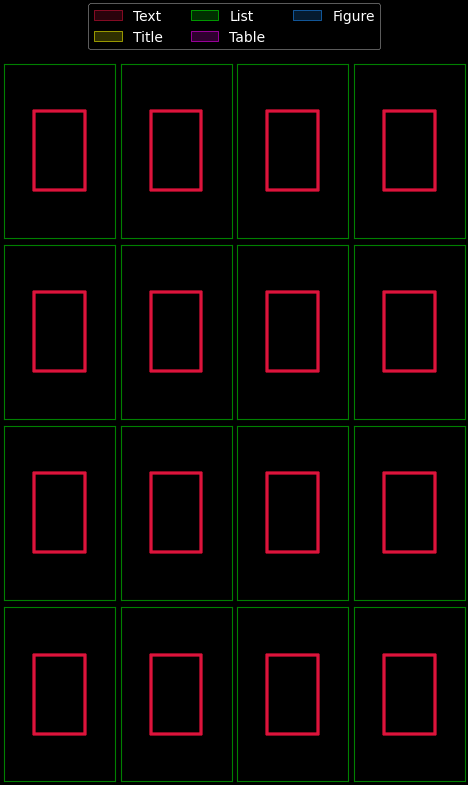

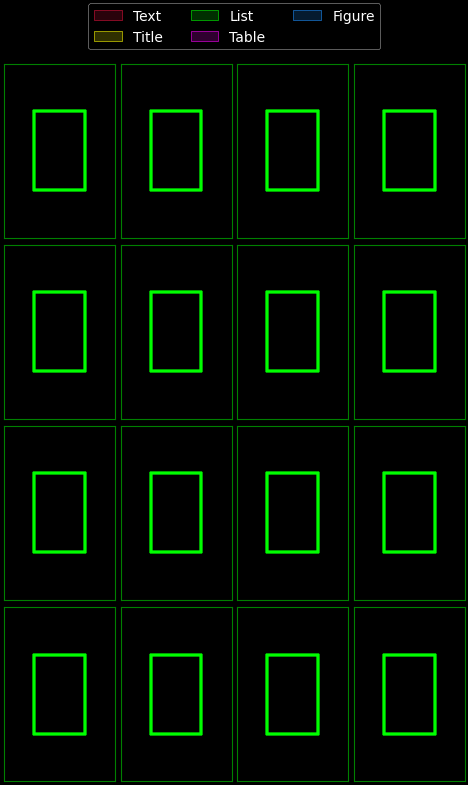

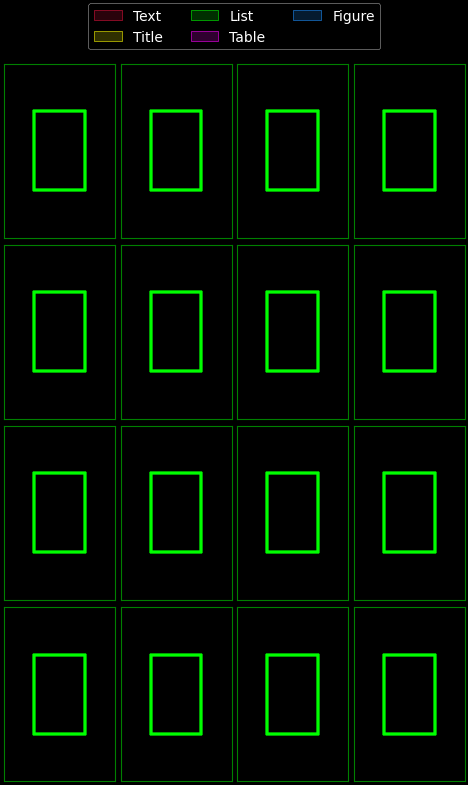

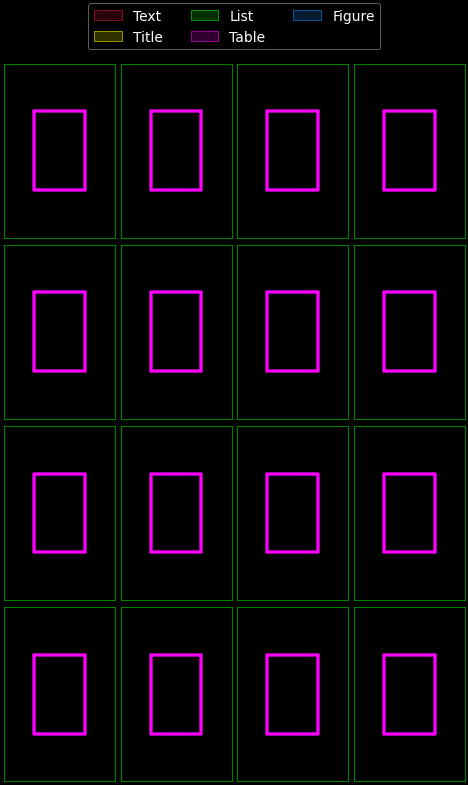

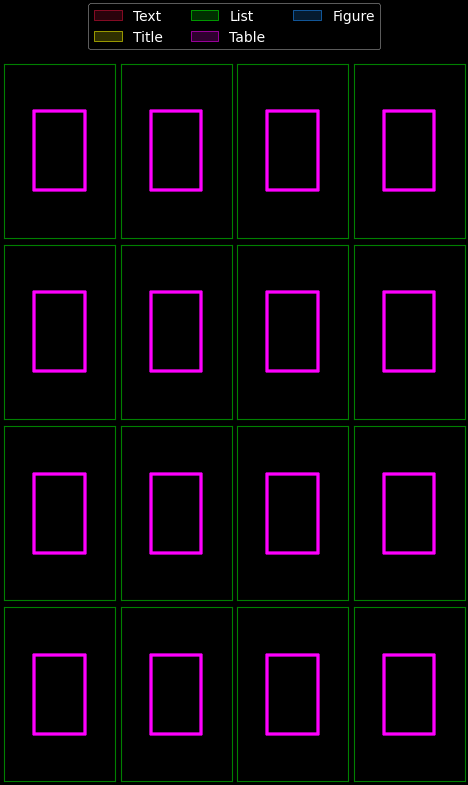

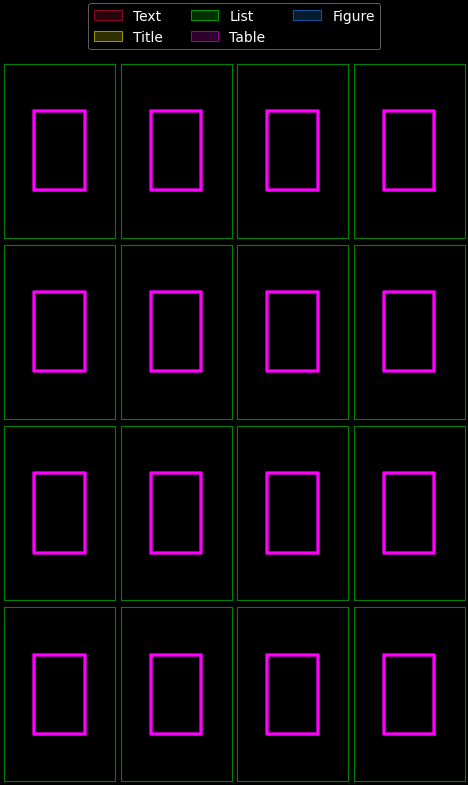

In [26]:

from __future__ import division
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt 

class LayoutGAN(object):
    # def __init__(self, geometric_dim=2, n_class=1, batch_size=64, n_component=128, layout_dim=(28,28),d_lr=1e-5,g_lr=1e-5,update_ratio=2,clip_value=0.1, dataset_name='default', dataset_path='./data/pre_data_cls.npy', checkpoint_dir=None, sample_dir=None):
    ## Changed by Aswin
    def __init__(self, geometric_dim=2, n_class=1, batch_size=64, n_component=128, layout_dim=(28,28),d_lr=2e-5,g_lr=2e-5,update_ratio=2,clip_value=0.1, dataset_name='default', dataset_path='./data/pre_data_cls.npy', checkpoint_dir=None, sample_dir=None):
        self.batch_size = batch_size
        self.n_component = n_component
        self.n_class    = n_class
        self.geometric_dim = geometric_dim
        self.layout_dim = layout_dim
        self.dataset_name  = dataset_name
        self.checkpoint_dir = checkpoint_dir
        self.data = np.load(dataset_path)
        self.build_model(d_lr,g_lr)
        self.sample_dir = sample_dir
        self.update_ratio=update_ratio
        self.clip_value = clip_value
        # self.epochs = 50
        self.epochs=5
        ## Changed by Aswin

    def build_model(self,d_lr,g_lr):
        self.G = self.build_generator()
        self.D = self.build_discriminator()
        epoch_step = len(self.data) // self.batch_size 
        # dlr = tf.keras.optimizers.schedules.ExponentialDecay(d_lr,decay_steps=20*epoch_step,decay_rate=0.1,staircase=True)
        dlr = tf.keras.optimizers.schedules.ExponentialDecay(d_lr,decay_steps=20*epoch_step,decay_rate=0.2,staircase=True)
        self.d_opt = tf.keras.optimizers.Adam(dlr)
        self.g_opt = tf.keras.optimizers.Adam(dlr)


    def step(self,real_data,noise,training=True,step=0):
        with tf.GradientTape() as disc_tape:
            disc_loss = self.discriminator_loss(real_data, noise)
            if(training):
                gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)
                self.d_opt.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

        for i in range (self.update_ratio):
            with  tf.GradientTape() as gen_tape:
                gen_loss = self.generator_loss(noise)
                if(training):
                    gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables)
                    self.g_opt.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables))

        return gen_loss, disc_loss              

    def train(self):
        epoch_step = len(self.data) // self.batch_size    
        sample = self.data[0:self.batch_size]
        sample_inputs = np.array(sample).astype(np.float32) 
        sample_z_bbox = np.random.normal(0.5, 0.15, (self.batch_size, 9, 4))
        sample_z_cls = np.identity(5)[np.random.randint(5, size=(self.batch_size, 9))]
        sample_z = np.concatenate([sample_z_bbox, sample_z_cls], axis=-1)
        counter = 1
        start_time = time.time()

        for epoch in range(self.epochs):
            np.random.shuffle(self.data)
            batch_idxs = len(self.data) // self.batch_size

            for idx in range(0, batch_idxs):
                batch = self.data[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_images = np.array(batch).astype(np.float32)

                batch_z_bbox = np.random.normal(0.5, 0.15, (self.batch_size, 9, 4))
                batch_z_cls = np.identity(5)[np.random.randint(5, size=(self.batch_size, 9))]
                batch_z = np.concatenate([batch_z_bbox, batch_z_cls], axis=-1)    

                g_loss, d_loss = self.step(batch_images,batch_z,step=idx)
                counter += 1
                if np.mod(counter, 1) == 0:
                    ## Changed by Aswin
                    
                    # current_decayed_lr = self.d_opt._decayed_lr(tf.float32).numpy()
                    # print("Epoch: [%2d] [%4d/%4d] time: %4.4f, lr:%.3E, d_loss: %.4f, g_loss: %.4f" \
                    #     % (epoch, idx, batch_idxs, time.time()-start_time, current_decayed_lr, d_loss, g_loss))
                    current_learning_rate = self.d_opt.learning_rate.numpy()
                    print("Epoch: [%2d] [%4d/%4d] time: %4.4f, lr:%.3E, d_loss: %.4f, g_loss: %.4f" \
                        % (epoch, idx, batch_idxs, time.time()-start_time, current_learning_rate, d_loss, g_loss))


                if np.mod(counter, 1) == 0:
                    ## Changed by Aswin
                    G_samples = self.G(sample_z, training = False)
                    path = '{}/train_{:02d}_{:04d}_{:2.4f}_{:2.4f}.jpg'.format(self.sample_dir, epoch, idx,d_loss, g_loss)                
                    change = convert_to_cxywh(np.array(G_samples))
                    plot_layouts(change,colors=colors,class_names=class_names,path = path)
                    g_loss, d_loss = self.step(sample_inputs,sample_z,training=False)
                    print("[Sample] d_loss: %.8f, g_loss: %.8f" % (d_loss, g_loss)) 
        
    def render(self):
        pass

    def build_discriminator(self): 
        return Discriminator(layout_dim=self.layout_dim,render=layout_bbox)
        
    def build_generator(self):
        return Generator(n_filters=1024,output_dim=self.geometric_dim,n_component=self.n_component,n_class=self.n_class)

    def generator_loss(self, z):
        x = self.G(z, training=True) 
        fake_score = self.D(x, training=True)
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_score, labels=tf.ones_like(tf.sigmoid(fake_score))))
        return g_loss

    def discriminator_loss(self, x, z):
        x_fake = self.G(z, training=True)
        true_score = self.D(x, training=True)
        fake_score = self.D(x_fake, training=True)
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = true_score, labels=tf.ones_like(tf.sigmoid(true_score))))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_score, labels=tf.zeros_like(tf.sigmoid(fake_score))))
        d_loss = d_loss_real + d_loss_fake
        return d_loss

if __name__ == '__main__':
    batch_size=64
    n_component=9
    n_class=5
    geometric_dim=4
    gan = LayoutGAN(batch_size=batch_size,n_component=n_component,
                    n_class=n_class,layout_dim=(60,40),
                    geometric_dim=geometric_dim,
                    sample_dir = sam_dir, 
                    dataset_path=dataset_path)
    
    gan.train()
    

In [ ]:
#predictions

results = []
for i in range(1000//64 + 1):
    sample_z_bbox = np.random.normal(0.5, 0.15, (64, 9, 4))
    sample_z_cls = np.identity(5)[np.random.randint(5, size=(64, 9))]
    sample_z = np.concatenate([sample_z_bbox, sample_z_cls], axis=-1)
    results.append(gan.G(sample_z))



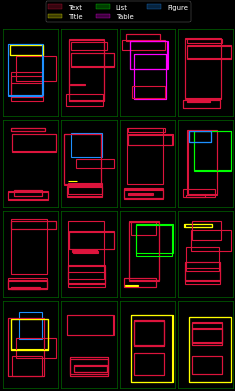

In [ ]:
change = convert_to_cxywh(results[0])
plot_layouts(change,colors=colors,class_names=class_names)